In [1]:
import math 
import random
import pygame
import numpy as np
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.5.2 (SDL 2.30.0, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# GLOBALS 
GRAVITY = 9.8
CART_MASS = 1
POLE_MASS = 0.1
TOTAL_MASS = CART_MASS + POLE_MASS
HALF_LENGTH = 1
FORCE = 10
TAU = 0.02
THETA_THRESHOLD_RADIANS = 12 * math.pi/180
X_THRESHOLD = 2.4
# Number of bins per dimension
x_bins     = np.linspace(-2.4,   2.4,   10)
v_bins     = np.linspace(-3.0,   3.0,   10)
th_bins    = np.linspace(-0.20943951, 0.20943951, 10)
om_bins    = np.linspace(-3.0,   3.0,   10)


In [3]:
class CartPoleEnv:
    def __init__(self,render = False):
        self.state = None # (x,x',th,th')
        self.render = render
        if render:
            pygame.init()
            self.screen_dimensions = (600,400)
            self.screen = pygame.display.set_mode(self.screen_dimensions)
            pygame.display.set_caption("CartPole")
            self.clock = pygame.time.Clock()
        self.reset()
    def reset(self):
        self.t = 0
        self.force_radii =[]
        self.state = (
            random.uniform(-0.01,0.01),
            random.uniform(-0.01,0.01),
            random.uniform(-0.01,0.01),
            random.uniform(-0.01,0.01)
        )
        return self.state
    def step(self,action):
        x,v,th,om = self.state
        force = action * FORCE
        if self.render and action != 0 :
            self.force_radii.append(action * 10)

        temp = (force + POLE_MASS * HALF_LENGTH * om * om * math.sin(th)) / TOTAL_MASS
        al = (GRAVITY * math.sin(th) - temp * math.cos(th))/ (HALF_LENGTH * (4/3 - (POLE_MASS * (math.cos(th))**2/TOTAL_MASS)))
        a = temp - HALF_LENGTH * POLE_MASS * math.cos(th) * al / TOTAL_MASS

        x += v*TAU
        v += a*TAU
        th+= om*TAU
        om+= al*TAU
        self.state = (x,v,th,om)
        self.t += 1

        done = x < -X_THRESHOLD or x > X_THRESHOLD or th < -THETA_THRESHOLD_RADIANS or th > THETA_THRESHOLD_RADIANS
        reward = 1 if not done else 0
        return self.state , reward , done 
    
    def render_animation(self):
        if not self.render: return
        self.width, self.height = self.screen_dimensions
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
        self.screen.fill((255,255,255))
        x, _, th, _ = self.state

        cart_y = int(self.height * 0.7)
        cart_x = int(self.width/2 + (x / X_THRESHOLD) * (self.width/2 - 50))
        cart_w, cart_h = 80, 30
        pygame.draw.rect(self.screen, (0,0,0), (cart_x - cart_w//2, cart_y - cart_h//2, cart_w, cart_h))

        pole_len = 100
        pole_dx = pole_len * math.sin(th)
        pole_dy = pole_len * math.cos(th)
        pygame.draw.line(self.screen, (200,0,0), (cart_x, cart_y), (cart_x + pole_dx, cart_y - pole_dy), 6)

        new_radii = []
        for radius in self.force_radii:
            dirn = (radius > 0) - (radius < 0)
            radius = abs(radius)
            radius *= 1.3
            alpha = max(0, min(255, int(200 * (1 - radius / 200))))
            if alpha > 0:
                surf = pygame.Surface(self.screen_dimensions, pygame.SRCALPHA)
                pygame.draw.circle(surf, (155,155,155,alpha), (self.width//2 + self.width//2 * dirn, self.height //2), int(radius))
                self.screen.blit(surf, (0, 0))
                if radius < 200:
                    new_radii.append((radius) * dirn)
        self.force_radii = new_radii
        pygame.display.flip()
        self.clock.tick(60)


In [4]:
def discretize(state):
    x, v, th, om = state

    bx  = int(np.digitize(x,  x_bins))
    bv  = int(np.digitize(v,  v_bins))
    bth = int(np.digitize(th, th_bins))
    bom = int(np.digitize(om, om_bins))

    return (bx, bv, bth, bom)

In [5]:
# SARSA Variables and states
Q = {}
LEARNING_RATE = 0.1
DISCOUNT = 0.99
EPSILON_INITIAL = 1
EPSILON_MIN = 0.05
EPSILON_DECAY_RATE = 0.00001
NUM_OF_LOOPS = 10000
EPISODE_COUNT = 0 
EPSILON = EPSILON_INITIAL
VISUALIZATION_INTERVAL = 10000

In [6]:
Env = CartPoleEnv(True)

In [7]:
# Epsilon Greedy Policy 
def egreedy(State):
    if State not in Q:
        Q[State] = {-1:0,0:0,1:0}
    if random.random() < EPSILON:
        return random.choice([-1,0,1])
    maxm = max(Q[State].values())
    return random.choice([x for x,val in Q[State].items() if val== maxm])

In [8]:
SCORES = []

In [ ]:
# Load and Save Q table 
def save_data_npz(Q, SCORES, filename="data.npz"):
    keys = np.array(list(Q.keys()), dtype=np.int16)  
    vals = np.array([list(Q[k].values()) for k in Q.keys()], dtype=np.float32)
    scores = np.array(SCORES,dtype = np.int16) 
    np.savez_compressed(filename, keys=keys, vals=vals,scores = scores)
    print(f"Saved data to {filename}")

def load_data_npz(filename = "data.npz"):
    global Q,SCORES,EPISODE_COUNT
    data = np.load(filename, allow_pickle=True)
    Q = {}
    for k, v in zip(data["keys"], data["vals"]):
        Q[tuple(k)] = {-1: v[0], 0: v[1],1:v[2]}

    print(f"Loaded from {filename}")
    SCORES = data["scores"].tolist()
    EPISODE_COUNT = len(SCORES)

save_data_npz(Q,SCORES)
# load_data_npz()

Saved data to data.npz


In [10]:
# Episodes to run 
for _ in range(300000):
    state = discretize(Env.reset())
    action = egreedy(state)
    while True:
        # if (EPISODE_COUNT%VISUALIZATION_INTERVAL == 0) :
        #     Env.render_animation()
        next_state , reward , done = Env.step(action)
        next_state = discretize(next_state)
        next_action = egreedy(next_state)
        Q[state][action] += LEARNING_RATE * (reward + DISCOUNT * Q[next_state][next_action] - Q[state][action])
        if done: break
        state = next_state
        action = next_action

    EPSILON = EPSILON_MIN + (EPSILON_INITIAL - EPSILON_MIN) * np.exp(-EPSILON_DECAY_RATE * EPISODE_COUNT)
    EPISODE_COUNT+=1
        
    SCORES.append(Env.t)

In [17]:
## Visualize a game 
PREV_EPSILON = EPSILON
EPSILON = 0
state = discretize(Env.reset())
action = egreedy(state)
while True:
    if (EPISODE_COUNT%VISUALIZATION_INTERVAL == 0) :
        Env.render_animation()
    next_state , reward , done = Env.step(action)
    next_state = discretize(next_state)
    next_action = egreedy(next_state)
    if done: break
    state = next_state
    action = next_action
EPSILON = PREV_EPSILON

Text(0.5, 1.0, 'Smoothed Episode Return (1000-episode MA)')

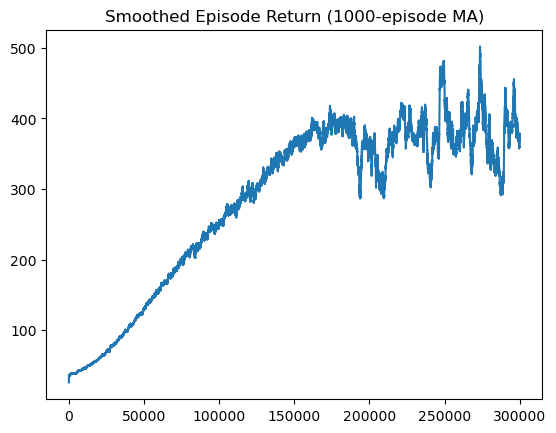

In [18]:
def moving_avg(data, k=1000):
    return [np.mean(data[max(0,i-k):i+1]) for i in range(len(data))]
plt.plot(moving_avg(SCORES))
plt.title("Smoothed Episode Return (1000-episode MA)")
